In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import itertools
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.model_selection import KFold
import ipywidgets as widgets
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import ipywidgets as widgets 

from scipy import stats

In [35]:

# Cargar el archivo CSV
data = pd.read_csv('insurance.csv')

# Supongamos que las columnas relevantes son 'age' y 'charges'
x = data['bmi'].values
y = data['charges'].values


<Axes: xlabel='bmi', ylabel='charges'>

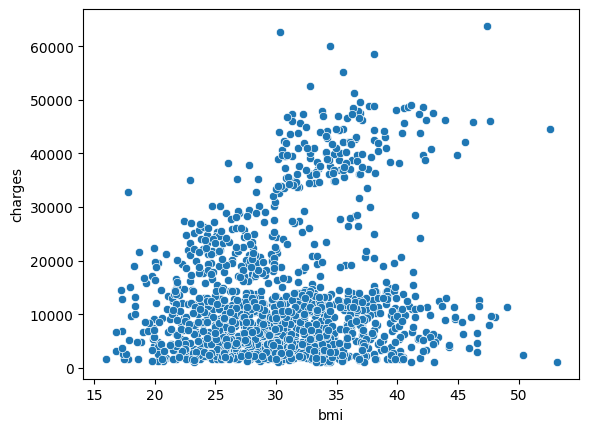

In [37]:
# Definir las variables independientes (predictores) y la variable dependiente
x = data[['age', 'bmi', 'children']]  # Selecciona las variables independientes de tu interés
y = data['charges']  # Selecciona la variable dependiente

# No necesitamos definir y_np ya que y representa directamente la variable dependiente

# Visualizar los datos
sns.scatterplot(x=x['bmi'], y=y)


In [43]:
def get_models(k, X, y):
    """
    Fit all possible models that contain exactly k predictors.
    """
    # List all available predictors
    X_combos = itertools.combinations(list(X.columns), k)
    
    # Fit all models accumulating Residual Sum of Squares (RSS)
    models = []
    for X_label in X_combos:
        # Parse patsy formula
        X_smf = ' + '.join(X_label)
        f     = '{} ~ {}'.format(y.columns[0], X_smf)
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Return results
        models += [(f, model)]
    return models


def min_rss(statsmodels):
    """Return model with lowest Residual Sum of Squares (RSS)"""
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]


def max_adjr2(statsmodels):
    """Return model with max R-squared"""
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]

def min_bic(statsmodels):
    """Return model with min Bayes' Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def min_aic(statsmodels):
    """Return model with min Akaike's Information Criteria"""
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].aic)[0]

SE TOMAN EN CUENTA LOS 6 COEFICIENTES QUE SE ENCUENTRAN CONTENIDOS EN LA BASE DE DATOS "INSURANCE.CSV", ENTRE ELLOS SE ENCUENTRAN: AGE, SEX, BMI, CHILDREN, SMOKER, REGION

In [54]:
data = pd.read_csv('insurance.csv')

# Supongamos que las columnas relevantes son 'age' y 'charges'
x = data['age'].values
y = data['charges'].values


data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)


X = pd.DataFrame({'age': x,
                  'bmi': x**2,
                  'children': x**3,
                  'sex': x**4,
                  'region': x**5,
                  'smoker': x**6,})
                  
y = pd.DataFrame({'y': y})

# get all model results
model_subsets = []
for k in range(len(X.columns)):
    k=k+1
    subset = get_models(k, X, y)
    model_subsets += [subset]
    print('Progess: k = {}, done'.format(k))

Progess: k = 1, done
Progess: k = 2, done
Progess: k = 3, done
Progess: k = 4, done
Progess: k = 5, done
Progess: k = 6, done


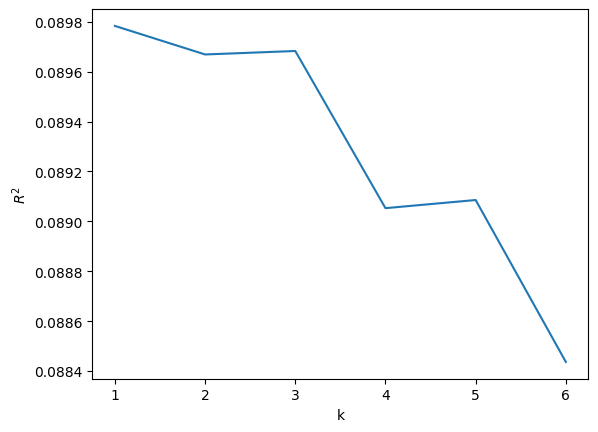

Model selected: 
Intercept    7658.734968
bmi             3.235437
dtype: float64


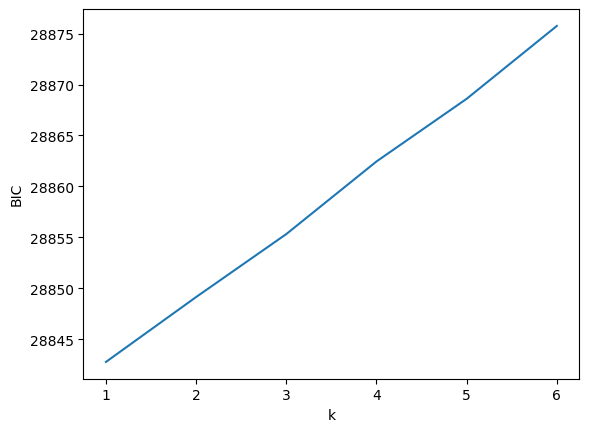

Model selected: 
Intercept    7658.734968
bmi             3.235437
dtype: float64


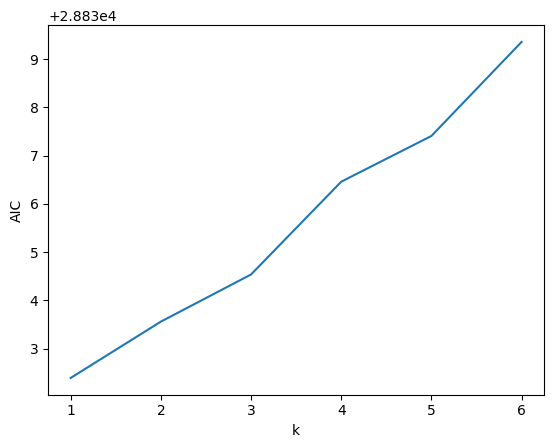

Model selected: 
Intercept    7658.734968
bmi             3.235437
dtype: float64


In [55]:
# Get predictor count
k = np.arange(1, len(X.columns)+1)

# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))

# Plot best r-squared score for each subset
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]

sns.lineplot(x=k, y=adjr2)
plt.xlabel('k')
plt.ylabel('$R^2$')
plt.show()

# Select best subset
coefs_r2 = [(max_adjr2(m)[1].rsquared_adj, max_adjr2(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(max(coefs_r2)[1]))


# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))

# Get best BIC
bic = [min_bic(m)[1].bic for m in model_subsets]

sns.lineplot(x=k, y=bic)
plt.xlabel('k')
plt.ylabel('BIC')
plt.show()

# Select best subset
coefs_bic = [(min_bic(m)[1].bic, min_bic(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(min(coefs_bic)[1]))


# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))

# Get best AIC
aic = [min_aic(m)[1].aic for m in model_subsets]

sns.lineplot(x=k, y=aic)
plt.xlabel('k')
plt.ylabel('AIC')
plt.show()

# Select best subset
coefs_aic = [(min_aic(m)[1].aic, min_aic(m)[1].params) for m in model_subsets]
print('Model selected: \n{}'.format(min(coefs_aic)[1]))

APLICACIÓN FORWARD STEPWISE SELECTION, TENIENDO EN CUENTA LOS 6 COEFICIENTES DE LA BASE DE DATOS DEL NEGOCIO DE LOS SEGUROS

In [56]:
def forward_stepwise(X, y, scorer='ssr', results=[(0, [])]):
    """Perform forward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.207)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds}).drop(0)
    
    # Get score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = '{} ~ {}'.format(y.columns[0], '+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r    += [(model, [p]+p_used)]
    
    # Choose predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 
                        
    new_results = results + [best_score]
    # Recursive call to self
    return forward_stepwise(X, y, scorer, new_results)

In [57]:
def backward_stepwise(X, y, scorer='ssr', results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = '{} ~ {}'.format(y.columns[0], '+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        if scorer == 'ssr':
            return backward_stepwise(X, y, scorer, [(model.ssr, p_all)])
        if scorer == 'rsquared_adj':
            return backward_stepwise(X, y, scorer, [(model.rsquared_adj, p_all)])
        if scorer == 'bic':
            return backward_stepwise(X, y, scorer, [(model.bic, p_all)])
        if scorer == 'aic':
            return backward_stepwise(X, y, scorer, [(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = '{} ~ {}'.format(y.columns[0], '+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model, p_test)]
    
    # Choose removal of predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 

    new_results = results + [best_score]
    # Recursive call to self
    return backward_stepwise(X, y, scorer, new_results)


def subset_analysis(df, scorer):
    """Renders results from forward_stepwise() and backward_stepwise()"""
    df['predictors_str'] = df['predictors'].astype(str)
    
    ax = sns.lineplot(x='predictors_str', y=scorer, data=df, sort=False)
    plt.xticks(rotation=90)
    plt.show();
    
    if scorer == 'rsquared_adj':
        display(df[df[scorer] ==  df[scorer].max()].drop('predictors_str', axis=1))
    else:
        display(df[df[scorer] ==  df[scorer].min()].drop('predictors_str', axis=1))

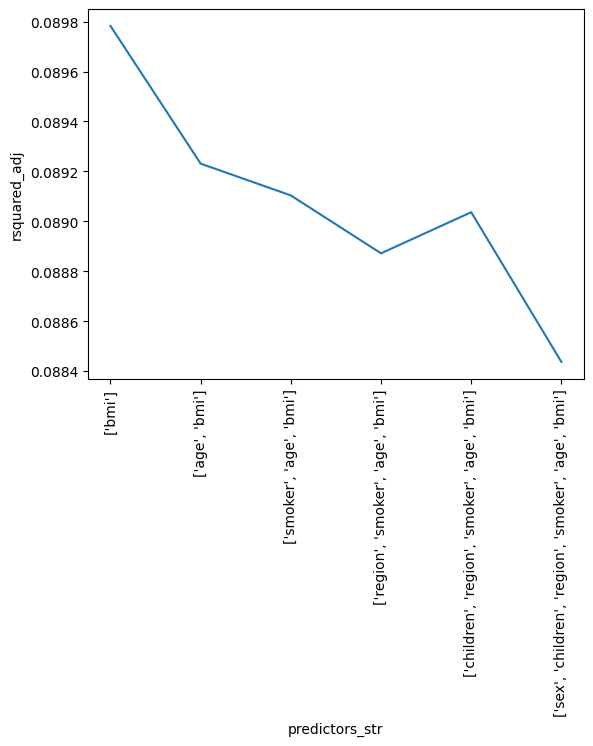

,rsquared_adj,predictors
1,0.089783,[bmi]


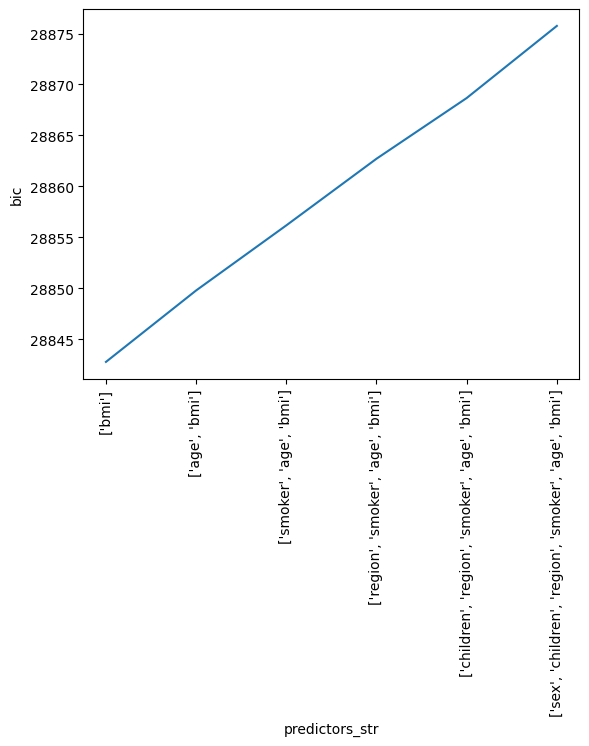

,bic,predictors
1,28842.791149,[bmi]


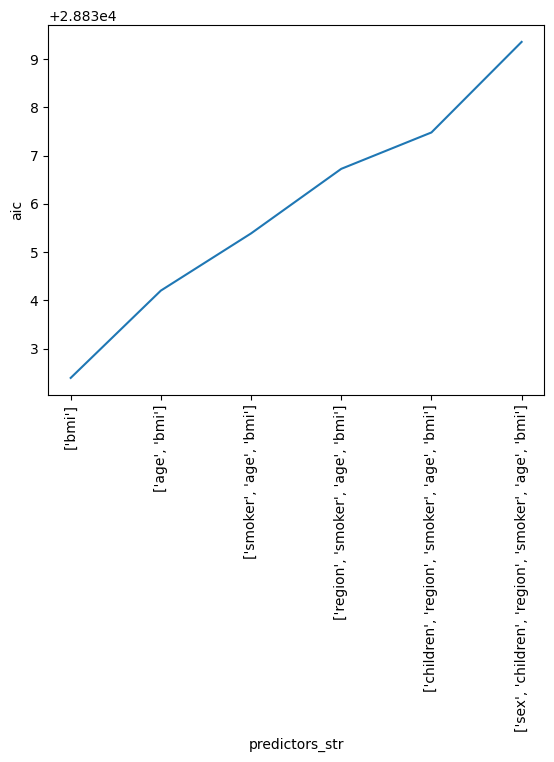

,aic,predictors
1,28832.393287,[bmi]


In [58]:
# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))
scorer = 'rsquared_adj'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))
scorer = 'bic'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))
scorer = 'aic'
subset_analysis(forward_stepwise(X, y, scorer=scorer), scorer)

APLICACIÓN BACKWARD STEPWISE SELECTION, TENIENDO EN CUENTA LOS 6 COEFICIENTES DE LA BASE DE DATOS DEL NEGOCIO DE LOS SEGUROS

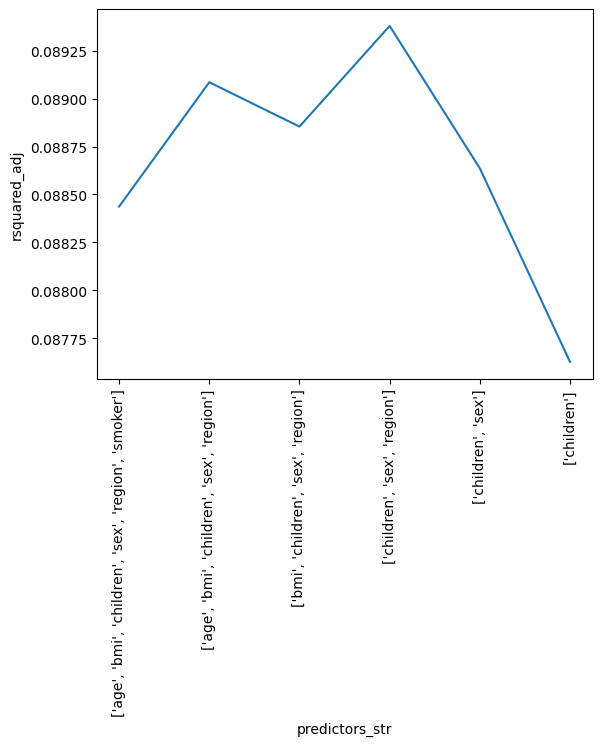

,rsquared_adj,predictors
3,0.089379,"[children, sex, region]"


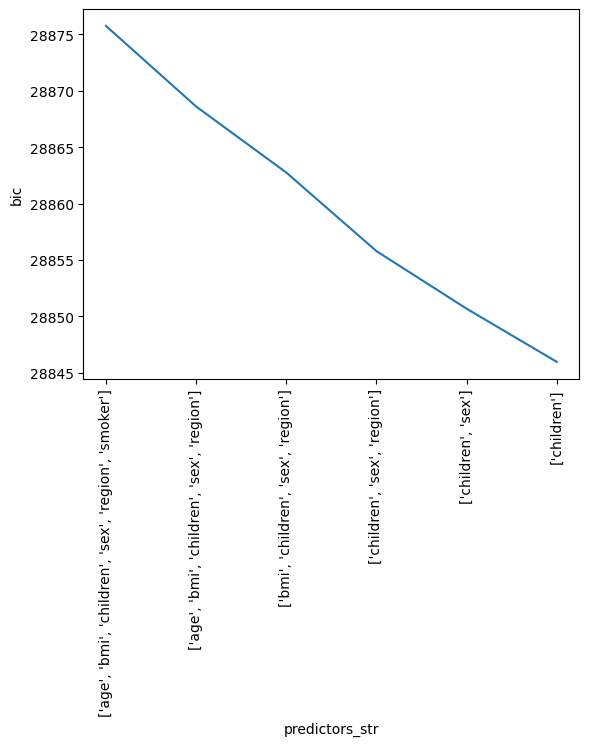

,bic,predictors
5,28845.958178,[children]


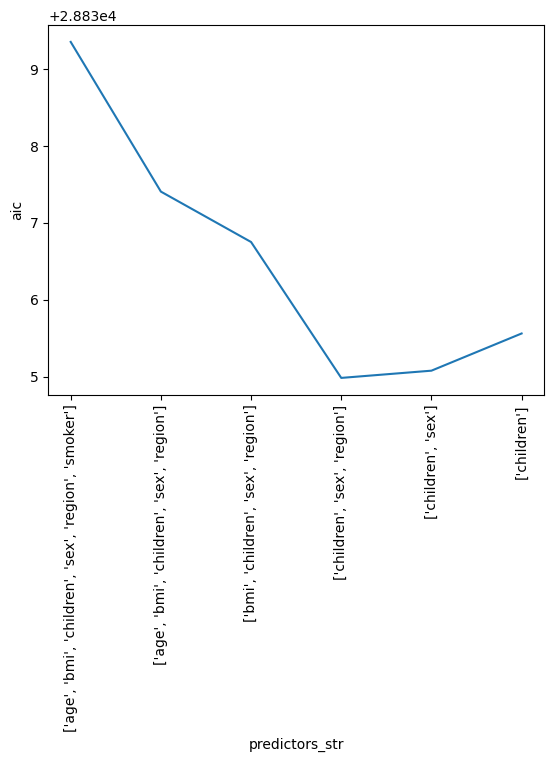

,aic,predictors
3,28834.982224,"[children, sex, region]"


In [59]:
# adjr2
# ------------------------------------------------
display(HTML('<h4>Adjusted R^2</h4>'))
scorer = 'rsquared_adj'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

# Bayes' Information Criteria (BIC)
# ------------------------------------------------
display(HTML('<h4>Bayes\' Information Criteria</h4>'))
scorer = 'bic'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)

# Akaike's Information Criteria (AIC/ C_p)
# ------------------------------------------------
display(HTML('<h4>Akaike\'s Information Criteria</h4>'))
scorer = 'aic'
subset_analysis(backward_stepwise(X, y, scorer=scorer), scorer)